In [1]:
import os
from typing import Any, Callable, Tuple

import numba
import pandas as pd
import numpy as np
import tensorflow as tf
import wandb
import tf2onnx
from scipy.spatial.transform import Rotation
from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow.keras.regularizers import l2
from wandb.keras import WandbCallback




In [2]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: eltoncn. Use `wandb login --relogin` to force relogin


True

# Data generation

Sample points between vertices. Random and random-sequential

In [25]:
@numba.njit
def sample_points(vertices:np.ndarray, n_point:int) -> np.ndarray:
    points = np.empty((n_point, 2))
    n_vertice = vertices.shape[0]

    for i in range(n_point):
        vertice1_index = np.random.randint(0, n_vertice)
        vertice2_index = vertice1_index + 1

        if vertice2_index == n_vertice:
            vertice2_index = 0

        vertice1 = vertices[vertice1_index]
        vertice2 = vertices[vertice2_index]

        alpha = np.random.rand(1)[0]

        points[i] = alpha * vertice1
        points[i] += (1-alpha) * vertice2
    
    return points

In [26]:
@numba.njit
def cmp_fn(l, r, *arrays):
    for a in numba.literal_unroll(arrays):
        if a[l] < a[r]:
            return -1  # less than
        elif a[l] > a[r]:
            return 1   # greater than

    return 0  # equal

@numba.njit
def quicksort(index, L, R, *arrays):
    l, r = L, R
    pivot = index[(l + r) // 2]

    while True:
        while l < R and cmp_fn(index[l], pivot, *arrays) == -1:
            l += 1
        while r >= L and cmp_fn(pivot, index[r], *arrays) == -1:
            r -= 1

        if l >= r:
            break

        index[l], index[r] = index[r], index[l]
        l += 1
        r -= 1

        if L < r:
            quicksort(index, L, r, *arrays)

        if l < R:
            quicksort(index, l, R, *arrays)

@numba.njit
def lexsort(arrays):

    if len(arrays) == 0:
        return np.empty((), dtype=np.intp)

    if len(arrays) == 1:
        return np.argsort(arrays[0])


    for a in numba.literal_unroll(arrays[1:]):
        if a.shape != arrays[0].shape:
            raise ValueError("lexsort array shapes don't match")

    n = arrays[0].shape[0]
    index = np.arange(n)

    quicksort(index, 0, n - 1, *arrays)
    return index

@numba.njit
def sample_points_sequential(vertices:np.ndarray, n_point:int) -> np.ndarray:
    points = np.empty((n_point, 2))
    n_vertice = vertices.shape[0]

    info = np.empty((n_point,2))

    for i in range(n_point):
        vertice1_index = np.random.randint(0, n_vertice)
        alpha = np.random.rand(1)[0]

        info[i][0] = vertice1_index
        info[i][1] = alpha

    ind = lexsort((info[:,0], info[:,1]))

    info = info[ind]

    for i in range(n_point):
        vertice1_index = int(info[i][0])
        alpha = info[i][1]

        vertice2_index = vertice1_index + 1

        if vertice2_index == n_vertice:
            vertice2_index = 0

        vertice1 = vertices[vertice1_index]
        vertice2 = vertices[vertice2_index]

        points[i] =  (1-alpha) * vertice1
        points[i] += alpha * vertice2
    
    return points

In [27]:
@numba.njit
def create_rotation_matrix(angle):
    angle = np.radians(angle)

    rotation_matrix = np.empty((2,2))
    rotation_matrix[0,0] = np.cos(angle)
    rotation_matrix[0,1] = -np.sin(angle)
    rotation_matrix[1,0] = -rotation_matrix[0,1]
    rotation_matrix[1,1] = rotation_matrix[0,0]

    return rotation_matrix

@numba.njit
def rotate_points(points:np.ndarray, angle:float) -> np.ndarray:

    points_r = points @ create_rotation_matrix(angle)

    return points_r

@numba.njit
def add_noise(points, std, add_chance, max_noise):
    n_points = points.shape[0]

    noise = np.random.normal(0, std, (n_points, 2))
    noise = np.clip(noise, -max_noise, max_noise)

    add_mask_x = np.random.rand(n_points) < add_chance
    add_mask_y = np.random.rand(n_points) < add_chance

    new_points = points.copy()
    new_points[add_mask_x, 0] += noise[add_mask_x, 0]
    new_points[add_mask_y, 1] += noise[add_mask_y, 1]

    return new_points


In [28]:
@numba.njit
def sample_with_transform(vertices, n_points, max_angle=360, std=0.1, add_chance=1.0, max_noise=0.05, sequential=False):
    points = np.empty((1,1))
    
    if sequential:
        points = sample_points_sequential(vertices, n_points)
    else:
        points = sample_points(vertices, n_points)

    angle = max_angle*np.random.rand(1)[0]
    points = rotate_points(points, angle)

    points = add_noise(points, std, add_chance, max_noise)

    return points

Pre-processing

In [14]:
@numba.njit
def center_points(points):
    center = np.array([points[:,0].mean(), points[:,1].mean()])
    return points.copy()-center

@numba.njit
def scale_unit(points):
    x_min = points[:,0].min()
    y_min = points[:,1].min()

    x_max = points[:,0].max()
    y_max = points[:,1].max()

    x_range = x_max - x_min
    y_range = y_max - y_min

    if x_range > y_range:
        scale = 1/x_range
    else:
        scale = 1/y_range

    return points.copy()*scale

Generation

In [30]:
@numba.njit
def generate_regular_vertices(n_side):
    angle_increment = 360/n_side

    angle = 0

    base_point = np.array([1,0], np.float64)
    vertices = np.empty((n_side, 2), np.float64)

    for i in range(n_side):
        rotation_matrix = create_rotation_matrix(angle)

        vertices[i] = rotation_matrix@base_point

        angle += angle_increment
    
    return vertices



In [137]:
@numba.njit
def generate_random_vertices(n_side):
    return np.random.rand(n_side, 2)

@numba.njit
def generate_random_vertices2():
    angle = 0
    angles = []

    while angle < 360:
        angles.append(angle)
        angle += 10*np.random.rand(1)[0]
    
    vertices = np.empty((len(angles), 2), np.float64)
    base_point = np.array([1,0], np.float64)

    for i in range(len(angles)):
        rotation_matrix = create_rotation_matrix(angles[i])
        vertices[i] = rotation_matrix@base_point

    return vertices


In [144]:
std_min = 1e-4
add_chance_min = 0.2

max_noise = 1e-1
std_max = 5e-2
add_chance_max = 1.0

@numba.njit
def create_dataset(samples_per_type, n_sides, random_vertices_min, random_vertices_max):
    n_sides = np.asarray(n_sides)

    n_type = len(n_sides) + 2

    features = np.empty((samples_per_type*n_type, 200))
    labels = np.empty(samples_per_type*n_type, np.int32)
    index = 0

    for i in range(len(n_sides)):
        vertices = generate_regular_vertices(n_sides[i])

        for _ in range(samples_per_type):
            std = np.random.uniform(std_min, std_max, 1)[0]
            add_chance = np.random.uniform(add_chance_min, add_chance_max, 1)[0]

            points = sample_with_transform(vertices, 100, 360, std, add_chance, max_noise, True)
            points = center_points(points)
            points = scale_unit(points)

            features[index] = points.flatten()
            labels[index] = i
            index += 1

    for _ in range(2*samples_per_type):
        std = np.random.uniform(std_min, std_max, 1)[0]
        add_chance = np.random.uniform(add_chance_min, add_chance_max, 1)[0]
        n_vertice = np.random.randint(random_vertices_min, random_vertices_max)
    
        vertices = generate_random_vertices(n_vertice)
    
        points = sample_with_transform(vertices, 100, 360, std, add_chance, max_noise, True)
        points = center_points(points)
        points = scale_unit(points)
    
        features[index] = points.flatten()
        labels[index] = len(n_sides)
        index += 1

    #for _ in range(samples_per_type):
    #    std = np.random.uniform(std_min, std_max, 1)[0]
    #    add_chance = np.random.uniform(add_chance_min, add_chance_max, 1)[0]
    #
    #    vertices = generate_random_vertices2()
    #
    #    points = sample_with_transform(vertices, 100, 360, std, add_chance, max_noise, True)
    #    points = center_points(points)
    #    points = scale_unit(points)
    #
    #    features[index] = points.flatten()
    #    labels[index] = len(n_sides)+1
    #    index += 1

    return features, labels



In [145]:
samples_per_type = 5000

features, labels = create_dataset(samples_per_type, np.array([3, 4, 5, 6]), 6, 12)

## Separation

In [146]:
total_samples = features.shape[0]
train_percentage = 0.7
val_percentage = 0.2
test_percentage = 0.1

In [147]:
indexes = np.random.choice(total_samples, size=total_samples, replace=False)

val_start = train_percentage+val_percentage

train_features = features[indexes[:int(train_percentage*total_samples)]]
train_targets = labels[indexes[:int(train_percentage*total_samples)]]

val_features = features[indexes[int(train_percentage*total_samples):int(val_start*total_samples)]]
val_targets = labels[indexes[int(train_percentage*total_samples):int(val_start*total_samples)]]

test_features = features[indexes[int(val_start*total_samples):]]
test_targets = labels[indexes[int(val_start*total_samples):]]


In [67]:
data = {
"train_features": train_features,
"train_targets": train_targets,
"val_features": val_features,
"val_targets": val_targets,
"test_features": test_features,
"test_targets": test_targets,
}

In [70]:
np.save("data_sygil4.npy", data)

In [3]:
data = np.load("data_sygil2.npy", allow_pickle=True).item()
train_features = data["train_features"]
train_targets = data["train_targets"]
val_features = data["val_features"]
val_targets = data["val_targets"]
test_features = data["test_features"]
test_targets = data["test_targets"]

In [68]:
n_features = 100*2
n_train = train_features.shape[0]
n_class = np.max([train_targets.max(), val_targets.max(), test_targets.max()])+1

In [69]:
n_class

5

# NN

In [4]:
def compile_fit(model, epochs, optimizer, batch_size, patience, units, regularizer, others=""):
    learning_rate = optimizer.learning_rate.numpy()
    
    config = {}
    config["leaning_rate"] = learning_rate
    config["epochs"] = epochs
    config["batch_size"] = batch_size
    config["optimizer"] = optimizer._name
    config["others"] = others

    config["layer0_units"] = units[0]
    config["layer0_l2"] = regularizer[0]

    if len(units) > 1:
        config["layer1_units"] = units[1]
        config["layer1_l2"] = regularizer[1]
    else:
        config["layer1_units"] = 0
        config["layer1_l2"] = 0

    run = wandb.init(project="SygilDetector", config = config)


    callbacks = []
    callbacks.append(keras.callbacks.EarlyStopping(monitor="val_sparse_categorical_crossentropy", patience=patience))
    callbacks.append(WandbCallback("val_sparse_categorical_crossentropy"))

    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_crossentropy", "accuracy"])

    hist = model.fit(train_features, train_targets, validation_data=(val_features, val_targets), epochs=epochs, batch_size=batch_size,
                callbacks=callbacks)

    wandb.finish()
    
    return hist


In [71]:
units = [400, 400]
regularizer = [0.0075, 0.0075]

model = keras.Sequential([keras.layers.Input(shape=(n_features), name="input"),
                    keras.layers.Dense(units[0], activation="relu", kernel_regularizer=l2(regularizer[0])),
                    keras.layers.Dropout(0.5),
                    keras.layers.Dense(units[1], activation="relu", kernel_regularizer=l2(regularizer[1])),
                    keras.layers.Dropout(0.5),
                    keras.layers.Dense(n_class, activation="softmax")])

optimizer = keras.optimizers.Adam(learning_rate=0.001)#(learning_rate=0.0005)
#optimizer = keras.optimizers.SGD(learning_rate=0.02)

hist = compile_fit(model, 1000, optimizer, 10000//2, 50, units, regularizer, "dropout[0.5, 0.5]")


Epoch 1/1000
4/4 [==============================] - 1s 68ms/step - loss: 6.4737 - sparse_categorical_crossentropy: 1.6531 - accuracy: 0.2018 - val_loss: 6.0493 - val_sparse_categorical_crossentropy: 1.5995 - val_accuracy: 0.2282
Epoch 2/1000
4/4 [==============================] - 0s 16ms/step - loss: 5.8897 - sparse_categorical_crossentropy: 1.6107 - accuracy: 0.2198 - val_loss: 5.5021 - val_sparse_categorical_crossentropy: 1.5750 - val_accuracy: 0.2444
Epoch 3/1000
4/4 [==============================] - 0s 15ms/step - loss: 5.3565 - sparse_categorical_crossentropy: 1.5877 - accuracy: 0.2489 - val_loss: 5.0048 - val_sparse_categorical_crossentropy: 1.5607 - val_accuracy: 0.4625
Epoch 4/1000
4/4 [==============================] - 0s 14ms/step - loss: 4.8761 - sparse_categorical_crossentropy: 1.5768 - accuracy: 0.2877 - val_loss: 4.5534 - val_sparse_categorical_crossentropy: 1.5494 - val_accuracy: 0.4679
Epoch 5/1000
4/4 [==============================] - 0s 26ms/step - loss: 4.4361 - sp

accuracy,▁▄▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█████████████████████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sparse_categorical_crossentropy,█▅▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▅▆▆▆▆▆▇▇▆▇▇▇▇▇▇███████████████████████
val_loss,█▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_sparse_categorical_crossentropy,█▅▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
GFLOPS,0.00024
accuracy,0.90834
best_epoch,984
best_val_sparse_categorical_crossentropy,0.22611


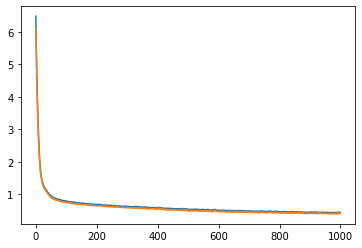

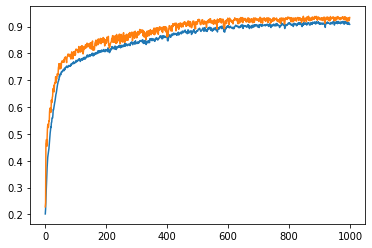

In [72]:
plt.plot(model.history.history["loss"])
plt.plot(model.history.history["val_loss"])

plt.show()

plt.plot(model.history.history["accuracy"])
plt.plot(model.history.history["val_accuracy"])

## Unity test

In [10]:
def sample_points_fromlist(points:np.ndarray, n_point:int) -> np.ndarray:
    indexes = np.random.choice(points.shape[0], size=n_point, replace=False)
    indexes = np.sort(indexes)


    return points[indexes]

In [12]:
df_triangle = pd.read_csv("Points_Triangle.csv", sep=";", decimal=",", names=["x", "y"])
all_points_tr = df_triangle.to_numpy()

In [94]:
points = sample_points_fromlist(all_points_tr, 100)
points = center_points(points)
points = scale_unit(points)

result = model(np.array([points.flatten()])).numpy()[0]

print(result)
print(np.argmax(result[:4]))

[6.2011808e-01 4.9349675e-03 1.7831384e-05 3.9548450e-08 3.7492913e-01]
0


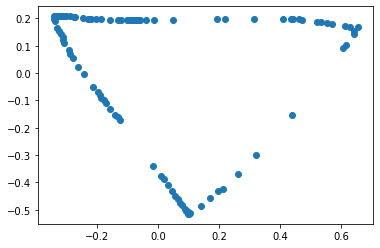

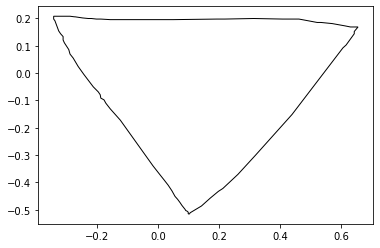

In [95]:
plt.plot(points[:,0], points[:,1], "o")
plt.show()

plt.fill(points[:,0], points[:,1], fill=False)
plt.show()



In [120]:
df = pd.read_csv("input.csv", sep=";", decimal=",", names=["x", "y"])
points = df.to_numpy()[100:]
points = center_points(points)
points = scale_unit(points)

result = model(np.array([points.flatten()])).numpy()[0]

print(result)
print(np.argmax(result))

[1.8976728e-02 9.7843343e-01 7.0569420e-04 5.2762334e-07 1.8835656e-03]
1


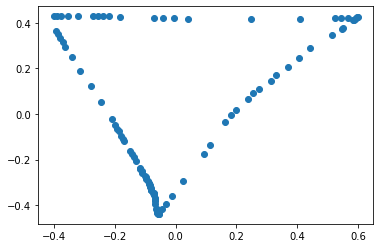

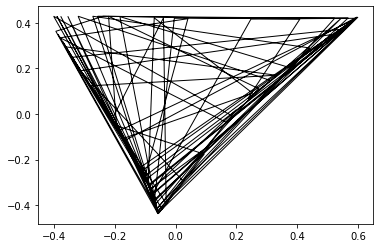

In [86]:
plt.plot(points[:,0], points[:,1], "o")
plt.show()

plt.fill(points[:,0], points[:,1], fill=False)
plt.show()



## Image

In [3]:
img_size = 100

In [ ]:


for i in range(10):
    points = train_features[i].reshape(100,2)

    img = np.zeros((img_size,img_size))
    for point in points:
        index = (point+1)/2
        index *= img_size
        index = index.astype(np.int32)

        img[index[0], index[1]] = 1

    print(train_targets[i])
    plt.imshow(img)
    plt.show()

In [16]:
def points2image(features):
    n_data = features.shape[0]

    img_features = np.empty((n_data, img_size, img_size, 1), np.uint8)

    for i in range(n_data):
        points = features[i].reshape(100,2)

        img = np.zeros((img_size,img_size))
        for point in points:
            index = (point+1)/2
            index *= img_size
            index = index.astype(np.int32)

            img_features[i, index[0], index[1], 0] = 255

    return img_features

In [159]:
img_features = points2image(features)

In [ ]:
total_samples = img_features.shape[0]
train_percentage = 0.7
val_percentage = 0.2
test_percentage = 0.1

indexes = np.random.choice(total_samples, size=total_samples, replace=False)

val_start = train_percentage+val_percentage

train_features = img_features[indexes[:int(train_percentage*total_samples)]]
train_targets = labels[indexes[:int(train_percentage*total_samples)]]

val_features = img_features[indexes[int(train_percentage*total_samples):int(val_start*total_samples)]]
val_targets = labels[indexes[int(train_percentage*total_samples):int(val_start*total_samples)]]

test_features = img_features[indexes[int(val_start*total_samples):]]
test_targets = labels[indexes[int(val_start*total_samples):]]

data = {
"train_features": train_features,
"train_targets": train_targets,
"val_features": val_features,
"val_targets": val_targets,
"test_features": test_features,
"test_targets": test_targets,
}

np.save("data_sygil_img.npy", data)

In [5]:
data = np.load("data_sygil_img.npy", allow_pickle=True).item()
train_features = data["train_features"]
train_targets = data["train_targets"]
val_features = data["val_features"]
val_targets = data["val_targets"]
test_features = data["test_features"]
test_targets = data["test_targets"]

In [6]:
n_train = train_features.shape[0]
n_class = np.max([train_targets.max(), val_targets.max(), test_targets.max()])+1

In [8]:
units = [400, 400]
regularizer = [0.0075, 0.0075]

model = keras.Sequential([keras.layers.Input(shape=(img_size, img_size, 1), name="input"),
                    keras.layers.Flatten(),
                    keras.layers.Dense(units[0], activation="relu", kernel_regularizer=l2(regularizer[0])),
                    keras.layers.Dropout(0.5),
                    keras.layers.Dense(units[1], activation="relu", kernel_regularizer=l2(regularizer[1])),
                    keras.layers.Dropout(0.5),
                    keras.layers.Dense(n_class, activation="softmax")])

optimizer = keras.optimizers.Adam(learning_rate=0.001)#(learning_rate=0.0005)
#optimizer = keras.optimizers.SGD(learning_rate=0.02)

hist = compile_fit(model, 1000, optimizer, 10000//2, 50, units, regularizer, "dropout[0.5, 0.5]")


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`
Epoch 1/1000
5/5 [==============================] - 2s 107ms/step - loss: 46.1189 - sparse_categorical_crossentropy: 38.0083 - accuracy: 0.3978 - val_loss: 9.9294 - val_sparse_categorical_crossentropy: 2.9501 - val_accuracy: 0.6889
Epoch 2/1000
5/5 [==============================] - 0s 46ms/step - loss: 13.8067 - sparse_categorical_crossentropy: 7.2002 - accuracy: 0.6241 - val_loss: 7.2873 - val_sparse_categorical_crossentropy: 1.2979 - val_accuracy: 0.7765
Epoch 3/1000
5/5 [==============================] - 0s 45ms/step - loss: 9.4117 - sparse_categorical_crossentropy: 3.6071 - accuracy: 0.6917 - val_loss: 6.4466 - val_sparse_categorical_crossentropy: 0.9295 - val_accuracy: 0.7750
Epoch 4/1000
5/5 [==============================] - 0s 45ms/step - loss: 7.7718 - sparse_categorical_crossentropy: 2.3293 - accuracy: 0.7169 - val_loss: 6.0342 - val_sparse_categorical_crossentropy: 0.6987 - val_accuracy

accuracy,▁▃▅▆▆▇▇▇▇▇▇█████████████████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▆▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sparse_categorical_crossentropy,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▃▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇███████████████████
val_loss,█▇▇▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_sparse_categorical_crossentropy,█▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
GFLOPS,0.00416
accuracy,0.99676
best_epoch,296
best_val_sparse_categorical_crossentropy,0.10799


In [33]:
points = sample_points_fromlist(all_points_tr, 100)
points = center_points(points)
points = scale_unit(points)

img = points2image(np.array([points]))

print(model(img).numpy()[0])
np.argmax(model(img))

[6.5890199e-01 2.6562536e-06 2.5961262e-07 1.0639899e-07 3.4109497e-01]


0

In [ ]:
result = model(np.array([points.flatten()])).numpy()[0]

print(result)
print(np.argmax(result[:4]))

In [6]:
def compile_fit_cnn(model, epochs, optimizer, batch_size, patience, units, regularizer, others=""):
    learning_rate = optimizer.learning_rate.numpy()
    
    config = {}
    config["leaning_rate"] = learning_rate
    config["epochs"] = epochs
    config["batch_size"] = batch_size
    config["optimizer"] = optimizer._name
    config["others"] = others

    run = wandb.init(project="SygilDetector", config = config)

    callbacks = []
    callbacks.append(keras.callbacks.EarlyStopping(monitor="val_sparse_categorical_crossentropy", patience=patience))
    callbacks.append(WandbCallback("val_sparse_categorical_crossentropy"))

    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_crossentropy", "accuracy"])

    hist = model.fit(train_features, train_targets, validation_data=(val_features, val_targets), epochs=epochs, batch_size=batch_size,
                callbacks=callbacks)

    wandb.finish()
    
    return hist


In [7]:
units = [400, 400]
regularizer = [0.0075, 0.0075]

#model = keras.Sequential([keras.layers.Input(shape=(img_size, img_size, 1), name="input"),
#                    keras.layers.Conv2D(16, (3,3), activation="relu", padding="same", kernel_regularizer=l2(regularizer[0])),
#                    keras.layers.MaxPooling2D((3,3)),
#                    keras.layers.Conv2D(32, (3,3), activation="relu", padding="same", kernel_regularizer=l2(regularizer[0])),
#                    keras.layers.MaxPooling2D((3,3)),
#                    keras.layers.Dense(100, activation="relu", kernel_regularizer=l2(regularizer[1])),
#                    keras.layers.Dropout(0.5),
#                    keras.layers.Dense(n_class, activation="softmax")])

model = keras.Sequential([keras.layers.Input(shape=(img_size, img_size, 1), name="input"),
                    keras.layers.Conv2D(16, (3,3), activation="relu", padding="same", kernel_regularizer=l2(regularizer[0])),
                    keras.layers.MaxPooling2D((3,3)),
                    keras.layers.Dense(100, activation="relu", kernel_regularizer=l2(regularizer[1])),
                    keras.layers.Dropout(0.5),
                    keras.layers.Dense(n_class, activation="softmax")])


optimizer = keras.optimizers.Adam(learning_rate=0.001)#(learning_rate=0.0005)
#optimizer = keras.optimizers.SGD(learning_rate=0.02)

hist = compile_fit_cnn(model, 1000, optimizer, 10000//2, 50, units, regularizer, "dropout[0.5, 0.5]")


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`
Epoch 1/1000


ResourceExhaustedError:  OOM when allocating tensor with shape[5000,33,33,16] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential/dense/Tensordot/transpose-0-1-TransposeNCHWToNHWC-LayoutOptimizer}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_1088]

Function call stack:
train_function


## Export

In [34]:
onnx_model = tf2onnx.convert.from_keras(model)

with open(os.path.join("sygil_detector_img1.onnx"), "wb") as f:
    f.write(onnx_model[0].SerializeToString())

model.save("sygil_detector_img1")

Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Assets written to: sygil_detector_img1\assets
